In [1]:
from snn_delays.snn import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.experimental_models.snn_delay_prun import P_DelaySNN
from snn_delays.utils.train_utils import train, get_device, propagate_batch, to_plot
from snn_delays.utils.test_behavior import tb_addtask
from snn_delays.utils.visualization_utils import plot_taus, plot_membrane_evolution
import numpy as np
device = get_device()

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0


In [ ]:
time_window = 50
batch_size = 128 # 128: anil kag

ckpt_dir = 'addtask_03_2025'

dataset = 'addtask_episodic'
#dataset = 'addtask' 

DL = DatasetLoader(dataset=dataset, caching='', num_workers=0, batch_size=batch_size, total_time=time_window)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()
#dataset_dict["time_ms"] = 2e3
dataset_dict["time_ms"] = 5

In [3]:
structure = (48, 2)

snn = P_DelaySNN(dataset_dict, structure=structure, connection_type='f', delay=(100,1), delay_type='h', delay_mask='random', n_pruned_delays=3,
           reset_to_zero=False, win=time_window, loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=True)

snn.set_network()
snn.use_amp = False
snn.model_name = f'addask_d_50'
snn.input2spike_th = None
snn.num_train_samples = batch_size

snn_mf = SNN(dataset_dict, structure=structure, connection_type='mf', delay=None, delay_type='',
           reset_to_zero=False, win=time_window, loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=True)

snn_mf.multi_proj = 3

snn_mf.set_network()
snn_mf.use_amp = False
snn_mf.model_name = f'addask_mf_50'
snn_mf.input2spike_th = None
snn_mf.num_train_samples = batch_size


snn_rnn = SNN(dataset_dict, structure=structure, connection_type='r', delay=None, delay_type='',
           reset_to_zero=False, win=time_window, loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=True)

snn_rnn.set_network()
snn_rnn.use_amp = False
snn_rnn.model_name = f'addask_rnn_50'
snn_rnn.input2spike_th = None
snn_rnn.num_train_samples = batch_size



[INFO] Delays: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

[INFO] Delays o: tensor([0])
5
Delta 

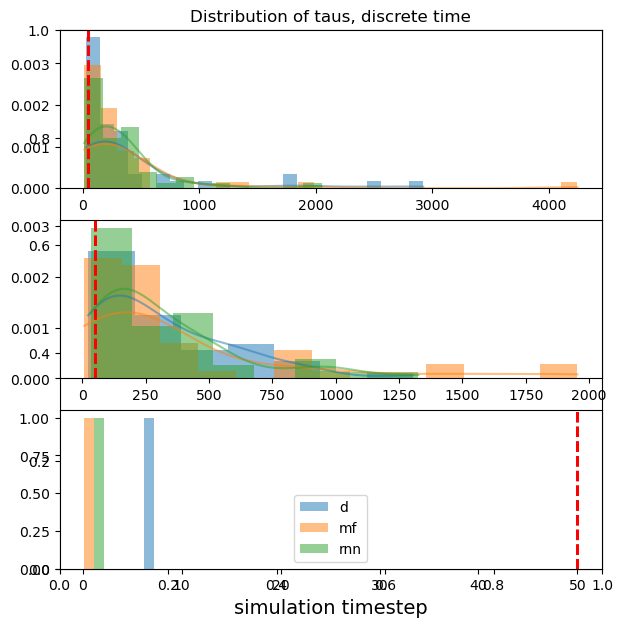

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plot_taus(snn, label='d')
plot_taus(snn_mf, label='mf')
plot_taus(snn_rnn, label='rnn')
plt.legend()

In [5]:
def propagate_batch_custom(snn, data):
    
    '''
    make first channel of input zero
    '''

    for images, labels in data:

        images = images*0 # make all zeros
        images[:, 10, 1] = 1 # put a single spike in the time 10
        
        snn.propagate(images, labels)
        break

    return images, labels

a, b = propagate_batch_custom(snn, test_loader)
a, b = propagate_batch_custom(snn_mf, test_loader)
a, b = propagate_batch_custom(snn_rnn, test_loader)


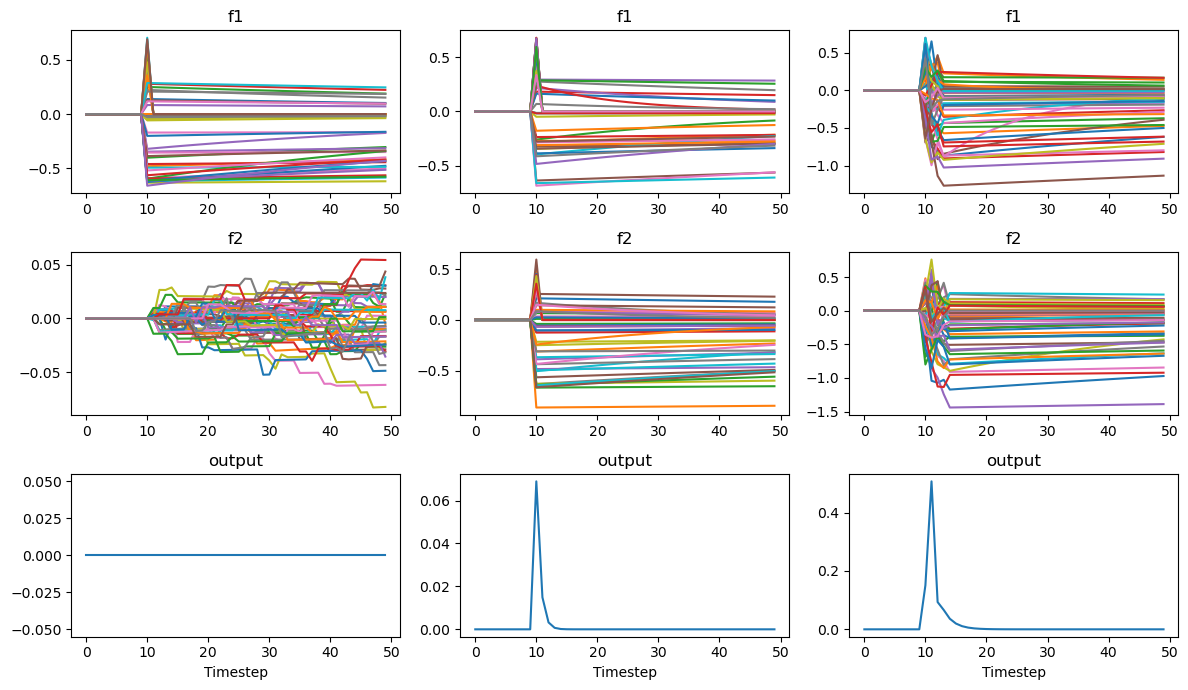

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(12, 7))  # 3 rows, 3 columns

plot_membrane_evolution(snn, axes[:, 0])      # First column
plot_membrane_evolution(snn_mf, axes[:, 1])  # Second column
plot_membrane_evolution(snn_rnn, axes[:, 2])  # Third column

plt.tight_layout()
plt.show()

In [7]:
train(snn_mf, train_loader, test_loader, 1e-3, 1000, ckpt_dir=ckpt_dir, test_behavior=tb_addtask, scheduler=(100, 0.95), clear=True)

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\sequential_tests_exp29
Mean Error: 0.00032835450838319957% 
--------------------------


In [8]:
train(snn, train_loader, test_loader, 1e-3, 1000, ckpt_dir=ckpt_dir, test_behavior=tb_addtask, scheduler=(100, 0.95), clear=True)

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\sequential_tests_exp29
Mean Error: 0.00018854984955396503% 
--------------------------


In [9]:
train(snn_rnn, train_loader, test_loader, 1e-3, 1000, ckpt_dir=ckpt_dir, test_behavior=tb_addtask, scheduler=(100, 0.95), clear=True)

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\sequential_tests_exp29
Mean Error: 0.0007490855641663074% 
--------------------------


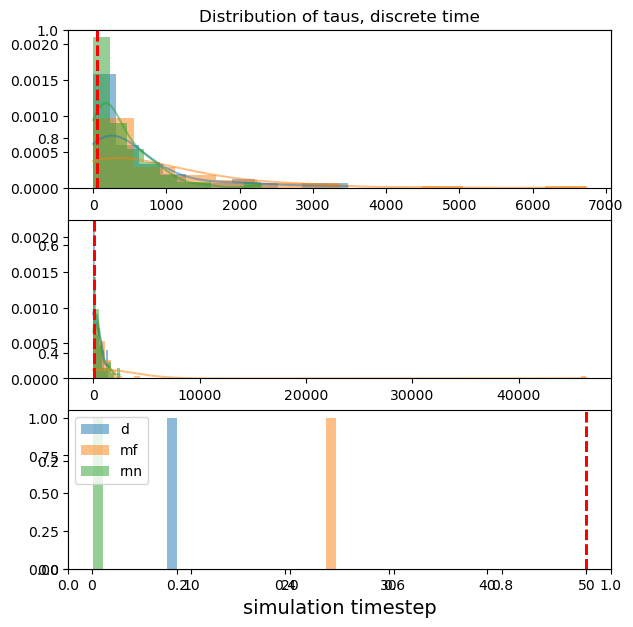

In [10]:
plt.figure(figsize=(7,7))
plot_taus(snn, label='d')
plot_taus(snn_mf, label='mf')
plot_taus(snn_rnn, label='rnn')
plt.legend()

Text(0.5, 1.0, 'train loss')

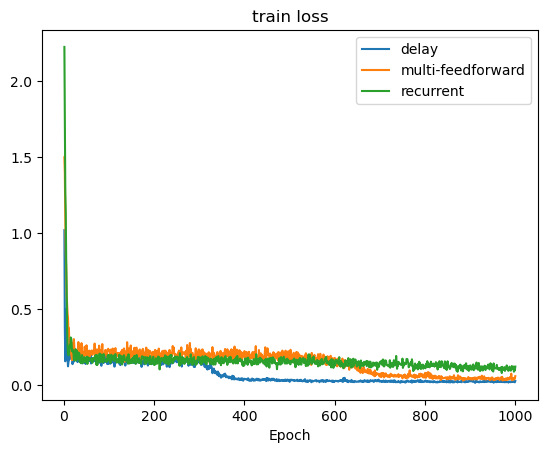

In [11]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
loss_error = np.mean(np.array(snn.train_loss)[:,1][-100:])
plot_per_epoch(snn.train_loss, label = 'delay')
plot_per_epoch(snn_mf.train_loss, label = 'multi-feedforward')
plot_per_epoch(snn_rnn.train_loss, label = 'recurrent')
#plt.title(f'loss error = {loss_error}')

#plt.ylim(0, loss_error)
plt.title('train loss')

<Axes: xlabel='simulation timestep'>

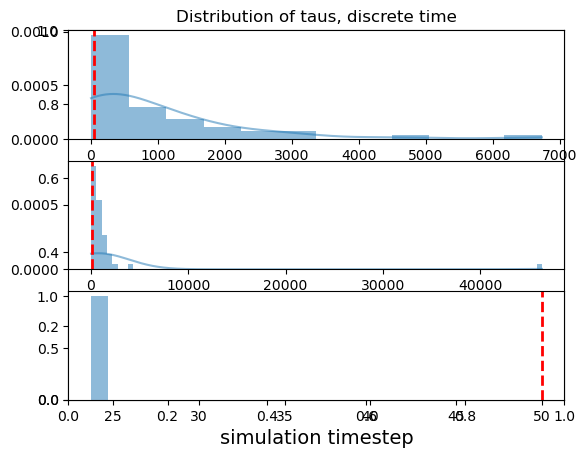

In [12]:
plot_taus(snn_mf, label='mf')

In [13]:
import torch

delta_t = snn_mf.dataset_dict.get('time_ms', 0)/snn.win

for i, pseudo_tau_m in enumerate(snn_mf.tau_m_h):

    real_tau = -delta_t/torch.log(torch.sigmoid(pseudo_tau_m))
    print(real_tau)
    print(f'average: {torch.mean(real_tau)}')

tensor([2.7598e+02, 5.4079e+01, 2.6267e+01, 9.0217e+00, 7.2097e+00, 2.2714e+01,
        1.4458e+02, 7.4490e-01, 1.0317e+02, 1.0307e+02, 9.4080e+00, 6.7319e+02,
        3.0072e+02, 1.7263e+02, 1.2240e+02, 9.9820e+01, 3.6015e+01, 8.4308e+01,
        1.1572e+01, 1.2266e+01, 7.0654e+00, 2.2713e+02, 2.9521e+01, 1.9774e+01,
        1.2017e+02, 2.0550e+02, 1.1863e+02, 1.0678e+01, 2.6766e-02, 3.1768e-02,
        1.8369e+01, 4.5573e+02, 1.5085e-01, 6.4656e-02, 6.7470e+00, 1.1098e+02,
        2.9102e+02, 5.1666e+01, 1.6819e+02, 1.6236e+01, 1.2653e+01, 2.6152e+01,
        9.2852e+01, 8.6113e-02, 8.8545e+01, 7.8928e+01, 2.0970e-01, 1.6986e+02],
       device='cuda:0', grad_fn=<MulBackward0>)
average: 95.75311279296875
tensor([3.0905e-02, 1.0776e+01, 5.0150e+01, 1.3256e+02, 1.0359e+02, 1.5629e+01,
        5.5759e+01, 8.1659e+01, 1.0434e+02, 6.7288e+01, 1.3009e+02, 1.0547e-01,
        6.8737e+01, 4.8411e+01, 7.7279e+01, 1.2358e+02, 6.7167e+00, 2.0704e+01,
        6.5653e+01, 4.1308e+01, 5.4706e+01, 

In [14]:
images, labels = propagate_batch(snn, test_loader)
_, labels_mf = propagate_batch(snn_mf, test_loader)
_, labels_rnn = propagate_batch(snn_rnn, test_loader)

In [15]:
ref = labels[:,:int(0.1*time_window),0].T.cpu().numpy()
out = snn.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

ref_mf = labels_mf[:,:int(0.1*time_window),0].T.cpu().numpy()
out_mf = snn_mf.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

ref_rnn = labels_rnn[:,:int(0.1*time_window),0].T.cpu().numpy()
out_rnn = snn_mf.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

-0.019613076
0.025937011
-0.033949208


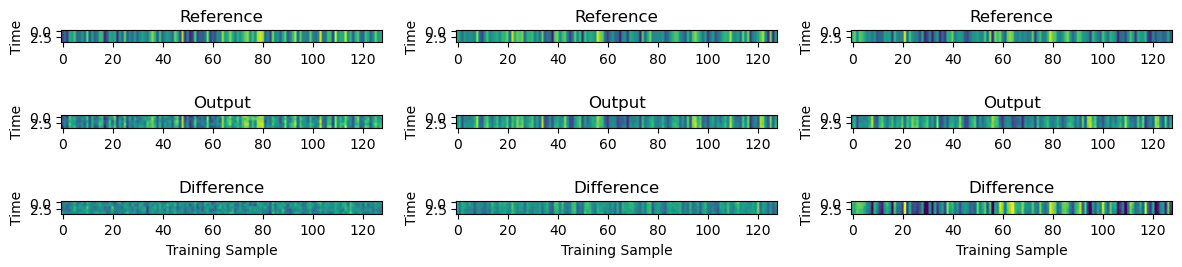

In [16]:
from snn_delays.utils.visualization_utils import plot_add_task, plot_add_task2, plot_add_task3, plot_add_task4
# Create a figure with 3 rows and N columns (for stacking results horizontally)
fig, axes = plt.subplots(3, 3, figsize=(12, 3))  # 3 rows, 3 columns

plot_add_task(out, ref, axes[:, 0])      # First column
plot_add_task(out_mf, ref_mf, axes[:, 1])  # Second column
plot_add_task(out_rnn, ref_rnn, axes[:, 2])  # Third column

plt.tight_layout()
plt.show()

<Axes: xlabel='Index', ylabel='Value'>

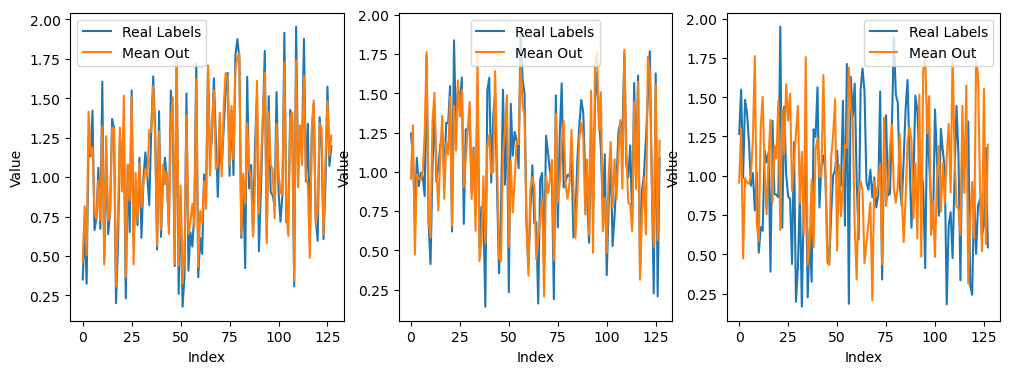

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plot_add_task2(out, labels)
plt.subplot(132)
plot_add_task2(out_mf, labels_mf)
plt.subplot(133)
plot_add_task2(out_rnn, labels_rnn)

<Axes: title={'center': 'output'}, xlabel='training sample', ylabel='time'>

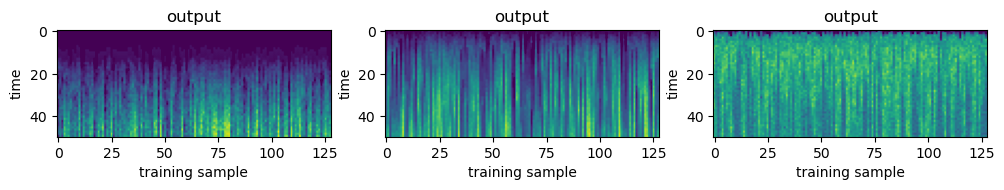

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plot_add_task3(snn)
plt.subplot(132)
plot_add_task3(snn_mf)
plt.subplot(133)
plot_add_task3(snn_rnn)

<Axes: title={'center': 'Dynamics of neuron = 0 of the layer output'}, xlabel='Time (ms)', ylabel='Membrane potential (mV)'>

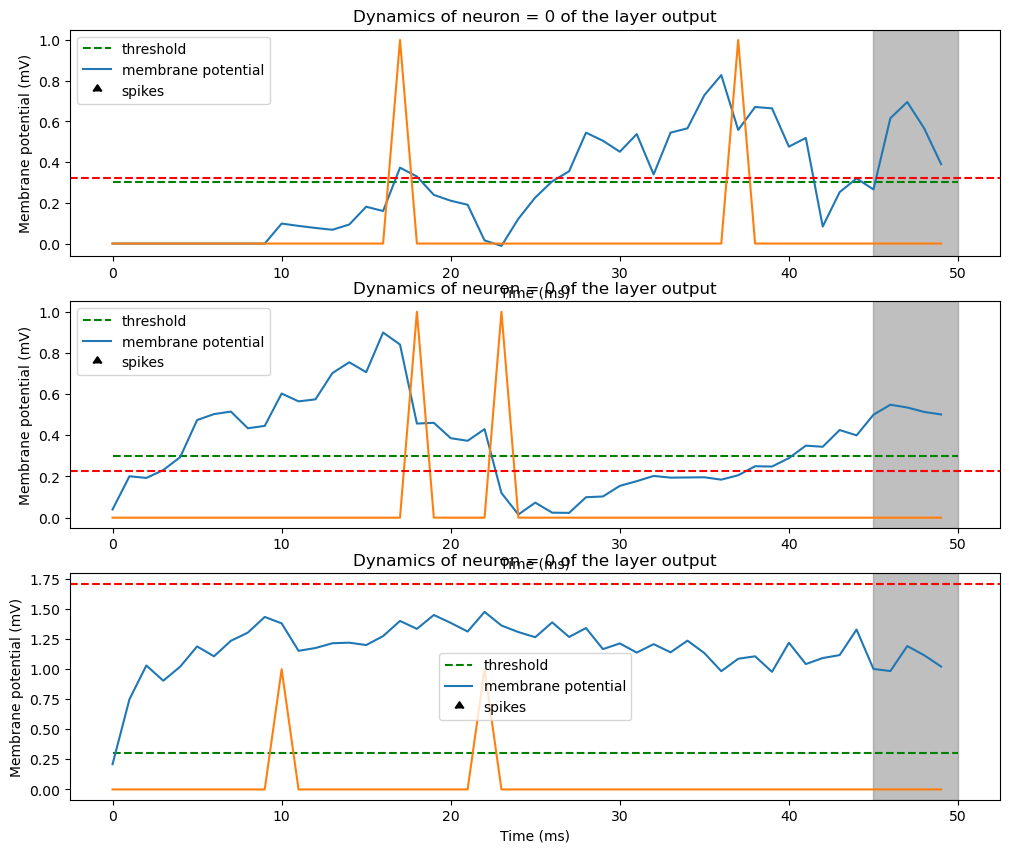

In [19]:
plt.figure(figsize=(12, 10))
plt.subplot(311)
plot_add_task4(snn)
plt.subplot(312)
plot_add_task4(snn_mf)
plt.subplot(313)
plot_add_task4(snn_rnn)

In [20]:
def get_errors_per_lapse(snn, num_trials):

    errors_per_lapse = [ [] for x in range(int(0.8*snn.win))]

    for trial in range(num_trials):

        _, labels = propagate_batch(snn, test_loader)
        ref = labels[:,:5,0].T.cpu().numpy()
        out = snn.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

        input_times = snn.spike_state['input'][:,:,1]

        outs = np.mean(out, axis=0)
        refs = np.mean(ref, axis=0)

        for sample in range(input_times.shape[1]):
            spike_times = torch.where(input_times[:, sample] == 1)[0]  # Get spike times
            dif = (spike_times[1] - spike_times[0]).item()
            errors_per_lapse[dif].append(abs(outs[sample]-refs[sample]))
    
    return errors_per_lapse


In [21]:
errors = get_errors_per_lapse(snn, 100)
errors_mf = get_errors_per_lapse(snn_mf, 100)
errors_rnn = get_errors_per_lapse(snn_rnn, 100)

In [22]:
def plot_errors(errors, label='Mean loss', linestyle='-'):

    # Example data: replace `nested_loss_lists` with your actual data
    #nested_loss_lists = tstloss_d['f_d_2l_hm_ft']

    # Ensure all lists have the same length and epoch indices
    #epochs = [entry[0] for entry in nested_loss_lists[0]]  # Epochs
    times = range(int(0.8*time_window))
    #all_losses = [np.array([entry[1] for entry in lst]) for lst in nested_loss_lists]

    mean_losses = np.array([np.mean(err) for err in errors])
    std_losses = np.array([np.std(err) for err in errors])

    # # Calculate average and standard deviation
    # mean_losses = np.mean(all_losses, axis=0)
    # std_losses = np.std(all_losses, axis=0)

    # Plot the average loss curve with error bars
    #plt.figure(figsize=(10, 6))
    plt.plot(times, mean_losses, label=label, linestyle=linestyle)
    #plt.fill_between(epochs, mean_losses - std_losses, mean_losses + std_losses, color=color, alpha=0.2, label='±1 Std Dev')
    plt.fill_between(times, mean_losses - std_losses, mean_losses + std_losses, alpha=0.2)
    #plt.title("Average Loss Curve")
    plt.xlabel("Interval")
    plt.ylabel("Absolute error")
    plt.legend()
    plt.grid(True)
    
    return plt.gca()

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Axes: xlabel='Interval', ylabel='Absolute error'>

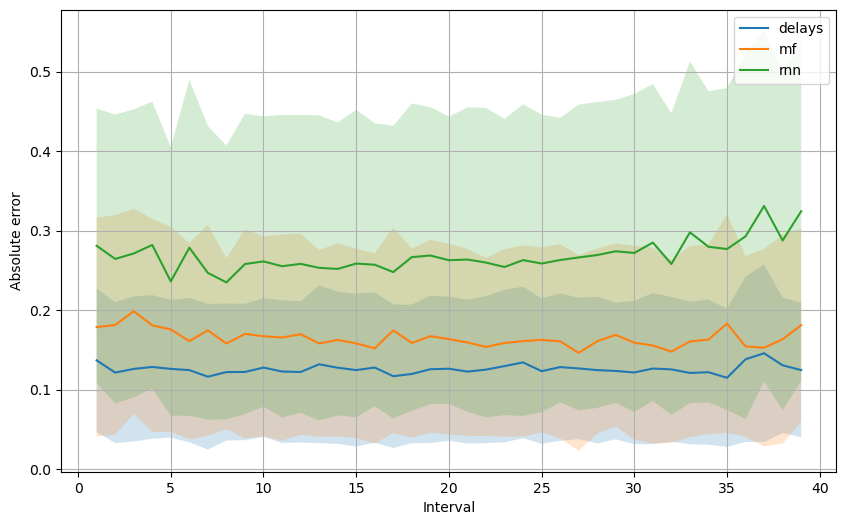

In [23]:
plt.figure(figsize=(10, 6))
plot_errors(errors, 'delays')
plot_errors(errors_mf, 'mf')
plot_errors(errors_rnn, 'rnn')

In [24]:
a, b = propagate_batch_custom(snn, test_loader)
a, b = propagate_batch_custom(snn_mf, test_loader)
a, b = propagate_batch_custom(snn_rnn, test_loader)

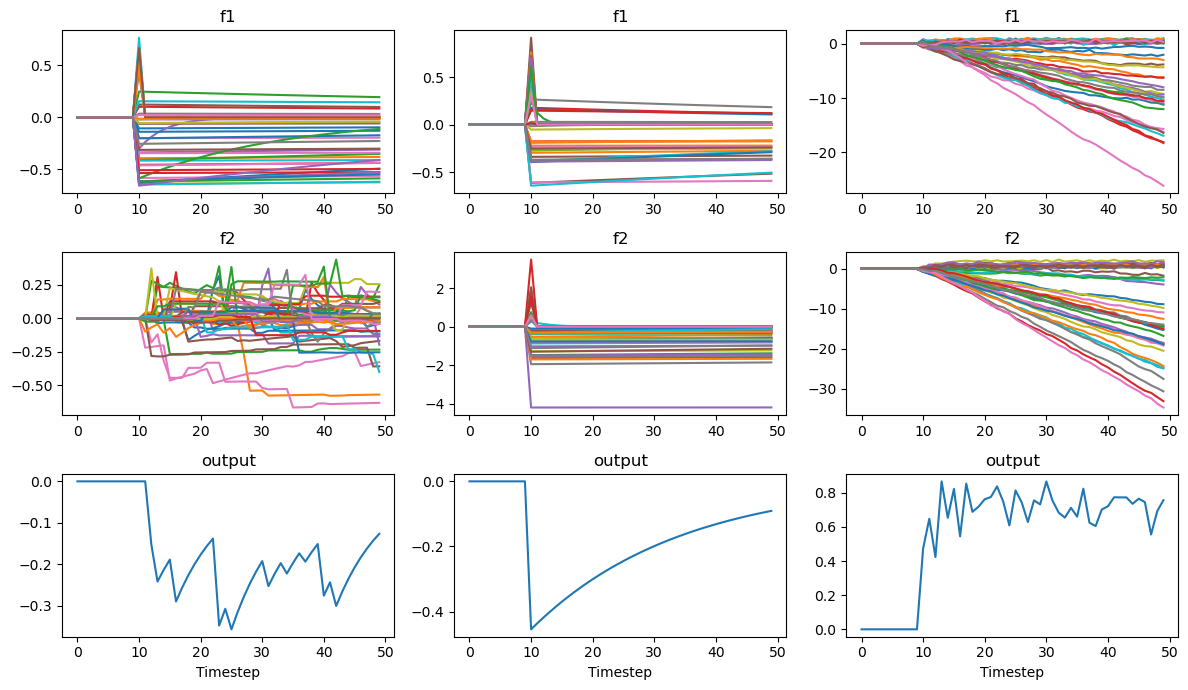

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(12, 7))  # 3 rows, 3 columns

plot_membrane_evolution(snn, axes[:, 0])      # First column
plot_membrane_evolution(snn_mf, axes[:, 1])  # Second column
plot_membrane_evolution(snn_rnn, axes[:, 2])  # Third column

plt.tight_layout()
plt.show()